Estimated monthly payment (mortgage + VvE) before tax deductions: €2,329


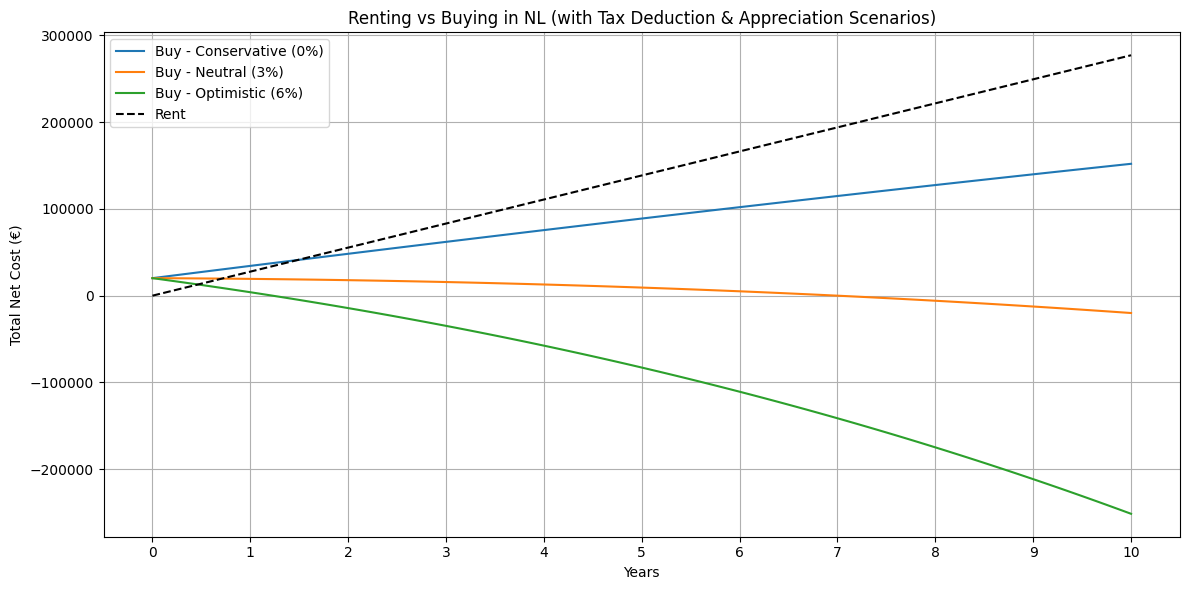

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === Input Parameters ===
rent_monthly = 2310          # Monthly rent in EUR
purchase_price = 500000      # Purchase price of the apartment in EUR
mortgage_rate_annual = 0.04  # Annual mortgage interest rate (e.g., 4%)
mortgage_years = 30          # Mortgage term in years
down_payment = 75000         # Initial down payment in EUR
vve_monthly = 300            # Monthly VvE (maintenance/association) fee
tax_deduction_rate = 0.3748  # Estimated 2025 tax benefit on mortgage interest (37.48%)
selling_costs_percentage = 0.015  # Selling costs as % of property value (e.g. agent fees, etc.)

# === One-time Upfront Costs for Buyers ===
upfront_costs_dict = {
    "transfer_tax": 0.02 * purchase_price if purchase_price > 525000 else 0,  # 2% transfer tax if price > €525,000
    "notary_fees": 1800,                # Notary for purchase and mortgage deeds
    "appraisal_fee": 700,              # Property valuation fee
    "mortgage_advisor": 2500,          # Financial/mortgage advice service
    "technical_inspection": 400,       # Building inspection
    "real_estate_agent": 0.013 * purchase_price,  # Buying agent fee (~1.3%)
    "bank_guarantee_fee": 500,         # Guarantee fee for the bank
    "bank_admin_fee": 300              # Bank administrative processing fee
}
upfront_costs = sum(upfront_costs_dict.values())  # Total one-time costs

# === Mortgage Setup ===
monthly_mortgage_rate = mortgage_rate_annual / 12
n_payments = mortgage_years * 12  # Total number of monthly mortgage payments
loan_amount = purchase_price - down_payment  # Amount borrowed from the bank

# === Monthly Mortgage Payment Calculation (Annuity Formula) ===
mortgage_monthly = loan_amount * (monthly_mortgage_rate * (1 + monthly_mortgage_rate)**n_payments) / \
                   ((1 + monthly_mortgage_rate)**n_payments - 1)

# === Time Horizon ===
years = 10
months = years * 12
time_months = np.arange(months + 1)  # Month-by-month time axis from 0 to 120

# === Property Appreciation Scenarios ===
appreciation_rates = {
    "Conservative (0%)": 0.00,  # No appreciation
    "Neutral (3%)": 0.03,       # 3% annual increase in property value
    "Optimistic (6%)": 0.06     # 6% annual increase in property value
}

# === Cumulative Rent Costs ===
cumulative_rent = time_months * rent_monthly  # Rent simply accumulates monthly

# === Begin Plotting Comparison of Rent vs Buy Scenarios ===
plt.figure(figsize=(12, 6))

# Loop through each appreciation scenario
for label, annual_appreciation in appreciation_rates.items():
    # === Initialize tracking arrays for each scenario ===
    cumulative_buy_cost = np.zeros_like(time_months, dtype=float)  # Total cash outflow
    property_value = np.zeros_like(time_months, dtype=float)       # Estimated property value over time
    remaining_balance = np.zeros_like(time_months, dtype=float)    # Outstanding loan at each time
    equity = np.zeros_like(time_months, dtype=float)               # Homeowner's equity over time
    net_buy_cost = np.zeros_like(time_months, dtype=float)         # True net cost (accounting for resale)

    # === Initial values at t = 0 ===
    cumulative_buy_cost[0] = down_payment + upfront_costs
    property_value[0] = purchase_price
    remaining_balance[0] = loan_amount
    equity[0] = property_value[0] - remaining_balance[0]
    net_buy_cost[0] = cumulative_buy_cost[0] - equity[0] + property_value[0] * selling_costs_percentage

    # === Monthly simulation loop ===
    for t in range(1, months + 1):
        # --- Mortgage calculations ---
        interest_payment = remaining_balance[t - 1] * monthly_mortgage_rate
        principal_payment = mortgage_monthly - interest_payment
        remaining_balance[t] = remaining_balance[t - 1] - principal_payment

        # --- Tax savings on interest ---
        tax_benefit = interest_payment * tax_deduction_rate

        # --- Net payment after tax deduction, plus monthly VvE ---
        net_payment = mortgage_monthly - tax_benefit
        cumulative_buy_cost[t] = cumulative_buy_cost[t - 1] + net_payment + vve_monthly

        # --- Property appreciation ---
        property_value[t] = property_value[t - 1] * (1 + annual_appreciation / 12)

        # --- Equity buildup ---
        equity[t] = property_value[t] - remaining_balance[t]

        # --- Net cost if selling at month t (includes cost to sell) ---
        selling_cost = property_value[t] * selling_costs_percentage
        net_buy_cost[t] = cumulative_buy_cost[t] - equity[t] + selling_cost

    # Plot the buying cost curve for this scenario
    plt.plot(time_months / 12, net_buy_cost, label=f'Buy - {label}')

# === Monthly Buyer Outflow (what you pay every month) ===
monthly_outflow = mortgage_monthly + vve_monthly
print(f"Estimated monthly payment (mortgage + VvE) before tax deductions: €{monthly_outflow:,.0f}")

# === Plot Rent Scenario ===
plt.plot(time_months / 12, cumulative_rent, '--k', label='Rent')

# === Final Plot Formatting ===
plt.xlabel('Years')
plt.ylabel('Total Net Cost (€)')
plt.title('Renting vs Buying in NL (with Tax Deduction & Appreciation Scenarios)')
plt.xticks(range(years + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
